# gensim

[Gensim](https://radimrehurek.com/gensim/) is a topic modeling API.

In [1]:
import pandas as pd
import numpy as np
import random

np.random.seed(37)
random.seed(37)

df = pd.DataFrame({
    'text': [
        'Data Science from Scratch: First Principles with Python',
        'Data Science for Business: What You Need to Know about Data Mining and Data-Analytic Thinking',
        'Practical Statistics for Data Scientists',
        'Build a Career in Data Science',
        'Python Data Science Handbook',
        'Storytelling with Data: A Data Visualization Guide for Business Professionals',
        'R for Data Science: Import, Tidy, Transform, Visualize, and Model Data',
        'Data-Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control',
        'A Hands-On Introduction to Data Science',
        'Intro to Python for Computer Science and Data Science: Learning to Program with AI, Big Data and The Cloud',
        'How Finance Works: The HBR Guide to Thinking Smart About the Numbers',
        'The Intelligent Investor: The Definitive Book on Value Investing. A Book of Practical Counsel',
        'Introduction to Finance: Markets, Investments, and Financial Management',
        'Python for Finance: Mastering Data-Driven Finance',
        'The Infographic Guide to Personal Finance: A Visual Reference for Everything You Need to Know',
        'Personal Finance For Dummies',
        'Corporate Finance For Dummies',
        'Lords of Finance: The Bankers Who Broke the World',
        'Real Estate Finance & Investments',
        'Real Estate Finance and Investments Risks and Opportunities'
    ],
    'clazz': [1 for _ in range(10)] + [0 for _ in range(10)]
})

df.shape

(20, 2)

In [2]:
df = pd.DataFrame({
    'text': [
        'Data Science from Scratch: First Principles with Python',
        'Data Science from Scratch: First Principles with Python',
        'Data Science from Scratch: First Principles with Python',
        'Data Science from Scratch: First Principles with Python',
        'Data Science from Scratch: First Principles with Python',
        'Data Science from Scratch: First Principles with Python',
        'Data Science from Scratch: First Principles with Python',
        'Data Science from Scratch: First Principles with Python',
        'Data Science from Scratch: First Principles with Python',
        'Data Science from Scratch: First Principles with Python',
        'How Finance Works: The HBR Guide to Thinking Smart About the Numbers',
        'How Finance Works: The HBR Guide to Thinking Smart About the Numbers',
        'How Finance Works: The HBR Guide to Thinking Smart About the Numbers',
        'How Finance Works: The HBR Guide to Thinking Smart About the Numbers',
        'How Finance Works: The HBR Guide to Thinking Smart About the Numbers',
        'How Finance Works: The HBR Guide to Thinking Smart About the Numbers',
        'How Finance Works: The HBR Guide to Thinking Smart About the Numbers',
        'How Finance Works: The HBR Guide to Thinking Smart About the Numbers',
        'How Finance Works: The HBR Guide to Thinking Smart About the Numbers',
        'How Finance Works: The HBR Guide to Thinking Smart About the Numbers'
    ],
    'clazz': [1 for _ in range(10)] + [0 for _ in range(10)]
})

df.shape

(20, 2)

In [3]:
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer() 
stop_words = set(stopwords.words('english') + list(string.punctuation))

is_valid = lambda t: t not in stop_words
tokenize = lambda t: word_tokenize(t.lower())
lemmatize = lambda t: lemmatizer.lemmatize(t)

df['normalized'] = df.text.apply(lambda text: [lemmatize(t) for t in tokenize(text) if is_valid(t)])
df.shape

(20, 3)

In [4]:
from itertools import chain
import nltk

dist = nltk.FreqDist(list(chain(*df.normalized)))
dist = pd.Series([v for _, v in dist.items()], dist.keys()).sort_values(ascending=False)
dist = dist[dist > 1]
valid_tokens = set(list(dist.index))

df['valid'] = df.normalized.apply(lambda tokens: [t for t in tokens if t in valid_tokens])
df.shape

(20, 4)

In [5]:
from gensim import corpora

dictionary = corpora.Dictionary(df.valid)
corpus = [dictionary.doc2bow(text) for text in df.valid]

In [6]:
from gensim import models

tfidf_model = models.TfidfModel(corpus)
corpus_tfidf = tfidf_model[corpus]

lsi_model = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2)
corpus_lsi = lsi_model[corpus_tfidf]

lda_model = models.LdaModel(corpus, id2word=dictionary, iterations=50, num_topics=2)
corpus_lda = lda_model[corpus]

In [7]:
import numpy as np

lsi_data = np.array([[tup[1] for tup in arr] for arr in corpus_lsi])
lda_data = np.array([[tup[1] for tup in arr] for arr in corpus_lda])

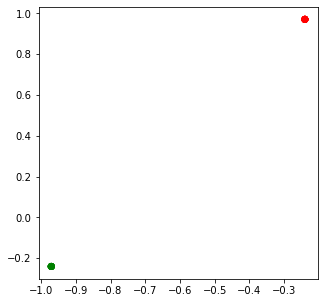

In [8]:
import matplotlib.pyplot as plt

x = lsi_data[:,0]
y = lsi_data[:,1]
c = ['r' if i == 0 else 'g' for i in df.clazz]

fig, ax = plt.subplots(figsize=(5, 5))
_ = ax.scatter(x, y, c=c)

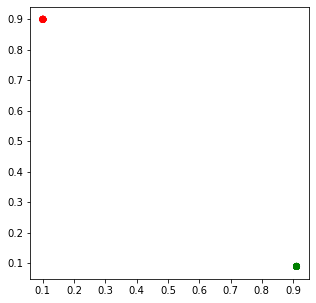

In [9]:
x = lda_data[:,0]
y = lda_data[:,1]
c = ['r' if i == 0 else 'g' for i in df.clazz]

fig, ax = plt.subplots(figsize=(5, 5))
_ = ax.scatter(x, y, c=c)

In [38]:
from scipy.special import softmax

lsi_weights = softmax(np.abs(lsi_model.get_topics()), axis=1)
lda_weights = softmax(np.abs(lda_model.get_topics()), axis=1)

In [39]:
lsi_weights

array([[0.08962502, 0.08962502, 0.08962502, 0.08962502, 0.08962502,
        0.08962502, 0.06603569, 0.06603569, 0.06603569, 0.06603569,
        0.06603569, 0.06603569, 0.06603569],
       [0.0659699 , 0.0659699 , 0.0659699 , 0.0659699 , 0.0659699 ,
        0.0659699 , 0.08631151, 0.08631151, 0.08631151, 0.08631151,
        0.08631151, 0.08631151, 0.08631151]])

In [43]:
lda_weights

array([[0.07748658, 0.07747555, 0.07763153, 0.07772958, 0.07731713,
        0.07776029, 0.0758833 , 0.07689781, 0.07651132, 0.07648929,
        0.0761646 , 0.0765026 , 0.07615064],
       [0.07542074, 0.07544924, 0.07504734, 0.07479621, 0.07586047,
        0.07471779, 0.07972662, 0.0769639 , 0.0780006 , 0.07806028,
        0.07894707, 0.07802421, 0.0789855 ]], dtype=float32)

In [46]:
np.exp(lda_model.get_topics() * 2)

array([[1.1835444, 1.1832078, 1.1879768, 1.1909797, 1.1783737, 1.1919211,
        1.1350734, 1.165627 , 1.1539396, 1.1532753, 1.1435046, 1.1536766,
        1.1430857],
       [1.1217574, 1.1226051, 1.1106778, 1.103257 , 1.1348761, 1.1009446,
        1.2534995, 1.1681311, 1.1998122, 1.2016488, 1.2291062, 1.2005388,
        1.2303033]], dtype=float32)

In [40]:
from wordcloud import WordCloud

def get_word_cloud_text(weights, id2token):
    d = {f'{id2token[i]}': int(w * 100.0) for i, w in enumerate(weights)}
    return d

def create_word_cloud(d):
    wc = WordCloud(background_color='black')
    wc.generate_from_frequencies(d)
    return wc

def plot_word_cloud(w, id2token):
    wc_texts = [get_word_cloud_text(w[r], id2token) for r in range(w.shape[0])]
    clouds = [create_word_cloud(text) for text in wc_texts]

    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    for ax, cloud in zip(axes, clouds):
        _ = ax.imshow(cloud, interpolation='bilinear')
        _ = ax.grid(False)
        _ = ax.axis('off')

    plt.tight_layout()

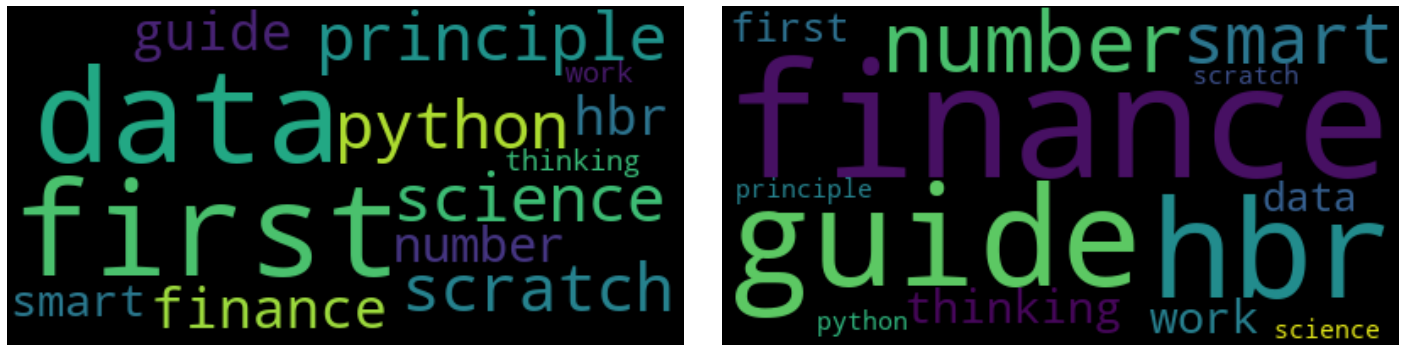

In [41]:
plot_word_cloud(lsi_weights, lsi_model.id2word.id2token)

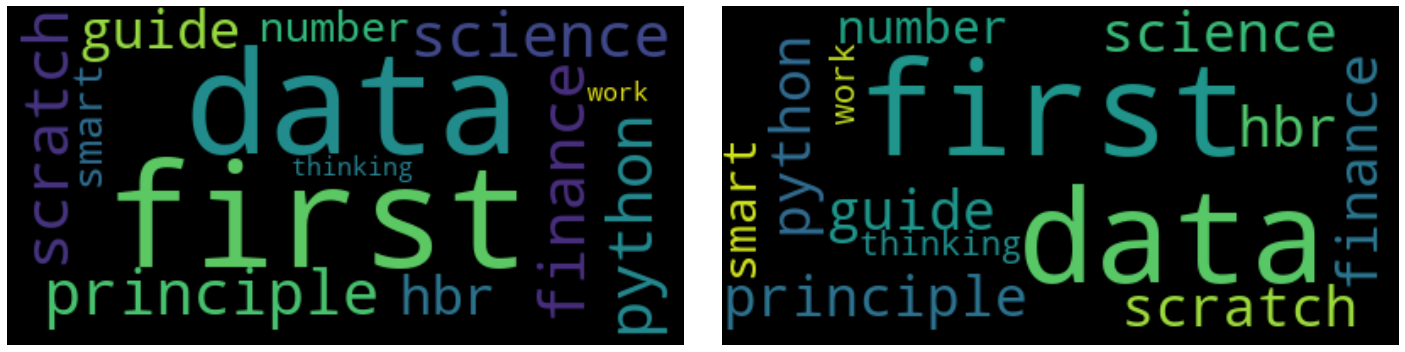

In [42]:
plot_word_cloud(lda_weights, lda_model.id2word.id2token)

In [14]:
from gensim.models.coherencemodel import CoherenceModel

lsi_cm = CoherenceModel(model=lsi_model, corpus=corpus_lsi, coherence='u_mass')
lda_cm = CoherenceModel(model=lda_model, corpus=corpus_lda, coherence='u_mass')

print('lsi', lsi_cm.get_coherence())
print('lda', lda_cm.get_coherence())

lsi -1.0627315813818545
lda -3.8966824650668332


In [15]:
lsi_cm = CoherenceModel(model=lsi_model, texts=df.valid, coherence='c_v')
lda_cm = CoherenceModel(model=lda_model, texts=df.valid, coherence='c_v')

print('lsi', lsi_cm.get_coherence())
print('lda', lda_cm.get_coherence())

lsi 0.08105956953597607
lda 0.08105956953597618


In [16]:
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, Birch
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=2, random_state=37).fit(lsi_data)
score = silhouette_score(lsi_data, kmeans.labels_)
score

1.0

In [17]:
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [18]:
kmeans = KMeans(n_clusters=2, random_state=37).fit(lda_data)
score = silhouette_score(lda_data, kmeans.labels_)
score

0.99996597

In [19]:
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [20]:
lsi_data

array([[-0.97068726, -0.24034609],
       [-0.97068726, -0.24034609],
       [-0.97068726, -0.24034609],
       [-0.97068726, -0.24034609],
       [-0.97068726, -0.24034609],
       [-0.97068726, -0.24034609],
       [-0.97068726, -0.24034609],
       [-0.97068726, -0.24034609],
       [-0.97068726, -0.24034609],
       [-0.97068726, -0.24034609],
       [-0.24034609,  0.97068726],
       [-0.24034609,  0.97068726],
       [-0.24034609,  0.97068726],
       [-0.24034609,  0.97068726],
       [-0.24034609,  0.97068726],
       [-0.24034609,  0.97068726],
       [-0.24034609,  0.97068726],
       [-0.24034609,  0.97068726],
       [-0.24034609,  0.97068726],
       [-0.24034609,  0.97068726]])

In [21]:
lda_data

array([[0.9106669 , 0.08933313],
       [0.9106507 , 0.08934934],
       [0.91065496, 0.08934505],
       [0.9106655 , 0.08933451],
       [0.91065   , 0.08935   ],
       [0.91066974, 0.08933027],
       [0.9106595 , 0.08934052],
       [0.9106944 , 0.08930556],
       [0.9106978 , 0.0893022 ],
       [0.9106722 , 0.08932778],
       [0.10053743, 0.8994626 ],
       [0.10056207, 0.89943796],
       [0.10059702, 0.899403  ],
       [0.10061262, 0.8993874 ],
       [0.10053937, 0.8994606 ],
       [0.10053638, 0.89946365],
       [0.10061103, 0.89938897],
       [0.10058767, 0.89941233],
       [0.10060246, 0.89939755],
       [0.10058405, 0.89941597]], dtype=float32)